# Lecture 8: Temporal Normalization (Z-Score) and Correlation

## Goals

- **Neuroscience / Neuroimaging concepts**
    - Correlating neural signals with experimental design
- **Datascience / Coding concepts**
    - Normalization
    - Z-scoring
    - Conceptual Interpretation of Correlation
    - Visual Intepretation of correlation
    - Algebraic Interpretation of correlation

# Key terms and concepts

# Setup

Simply run the cells below that contain all the Python modules we'll neeed, plus setup matplotlib for plotting in this jupyter notebook.

In [1]:
# Load some necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy
import scipy.stats
import nibabel
import cortex
import os
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, widgets

### Helper function for loading data
Remember coding a function for loading brain data two homeworks ago? Here we can reuse it!

In [2]:
def load_nifti(file_name, mask=None):
    img = nibabel.load(file_name)
    data = img.get_data().T
    if mask is None:
        masked_data = data
    else:
        masked_data = data[:, mask]
    return masked_data

# Review

## Convolution

Last lecture we learned about event related designs in comparison to block designs. We learned about how it becomes absolutely critical to take the hemodynamic response lag into account if our experiment utilizes rapid successions of events. 

We learned that the operation by which we can go from a time series representing the experimental events (blocks or short events) to a timeseries that resembles the BOLD response is *convolution* of the experimental time series with the *hemodynamic response function (HRF)*.

Let's take another quick look at this to refresh our memory.

We'll first load the labels of our category localizer, convolve the blocks with the HRF, then load a voxel time series from FFA and one from PPA and compare.

In [3]:
category_labels = np.load("/home/jovyan/catloc_experimental_conditions.npy")

In [4]:
category_labels[:20]

array(['faces', 'faces', 'faces', 'faces', 'faces', 'faces', 'faces',
       'faces', 'faces', 'faces', 'object', 'object', 'object', 'object',
       'object', 'object', 'object', 'object', 'object', 'object'], 
      dtype='<U9')

Let's load the data from the midterm and extract some voxel time series which we know vary with the stimulus:

In [5]:
filename = "/home/jovyan/s01_categories_all_z.nii"
midterm_data = load_nifti(filename)

In [6]:
midterm_data.shape

(360, 30, 100, 100)

We specify the voxel location for a face selective voxel in FFA, and then read it into `z, y, x` coordinates, and use these to extract the time series.

In [7]:
face_voxel_loc = (6, 57, 37)

z, y, x = face_voxel_loc
faces_timeseries = midterm_data[:, z, y, x]

In [8]:
faces_timeseries.shape

(360,)

Remember, this time series is currently not centered around zero, as we can see if we take the mean:

In [9]:
faces_timeseries.mean()

407.49158

Let's subtract this mean out to center the time series.

In [10]:
faces_timeseries_centered = faces_timeseries - faces_timeseries.mean()

Now let's plot the two time series as line plots to do a quick comparison of this time series to the stimulus vector for faces.

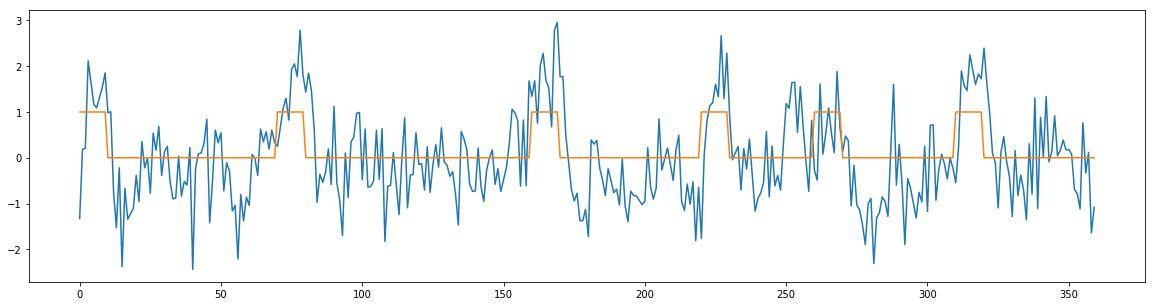

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(faces_timeseries_centered)
plt.plot(category_labels == 'faces')

Let's also create a hemodynamic response function, which we will use to convert the stimulus vector to the response vector.

In [12]:
from nistats.hemodynamic_models import glover_hrf as create_hrf

In [13]:
hrf = create_hrf(tr=2, oversampling=1)

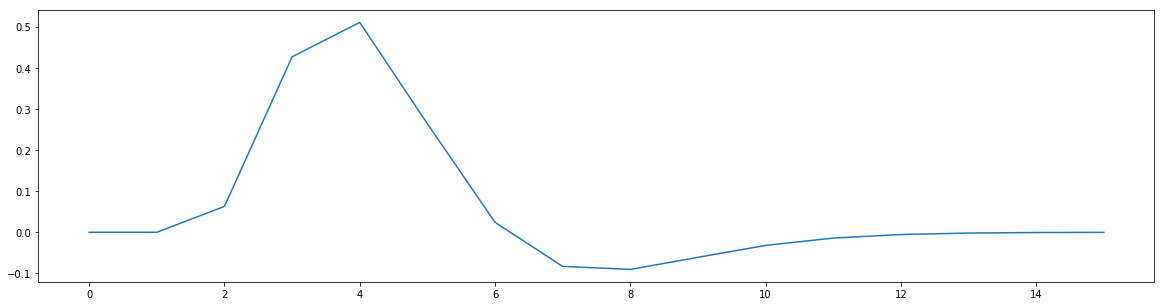

In [14]:
plt.figure(figsize=(20, 5))
plt.plot(hrf)

In the homework, you wrote a function to perform convolution. Let's recall what convolution does and take another look at the function.

Convolution combines two signals, for example the stimulus vector and the hrf, by moving one signal across the other and incrementing an output array by the product of the two at every shift.

It is used, for example, to compute the response of a system with certain assumed properties (linear and time-invariant), to a stimulus.

Let's take another close look at the code:

In [15]:
def convolution(stimulus, impulse_response):
    # output length for a full convolution will be longer than the stimulus
    out_length = len(stimulus) + len(impulse_response) - 1
    # preallocate output
    output = np.zeros(out_length)
    # iterate over entries of stimulus
    for i in range(len(stimulus)):
        # get current stimulus value
        cur_stim_val = stimulus[i]
        # multiply impulse response by this stimulus value
        multiplied_response = cur_stim_val * impulse_response
        # add multiplied response to output starting at position i
        output[i:i + len(impulse_response)] += multiplied_response
    return output

In [16]:
faces_stimulus = category_labels == 'faces'
faces_response = convolution(faces_stimulus, hrf)
faces_stimulus.shape, faces_response.shape, hrf.shape

((360,), (375,), (16,))

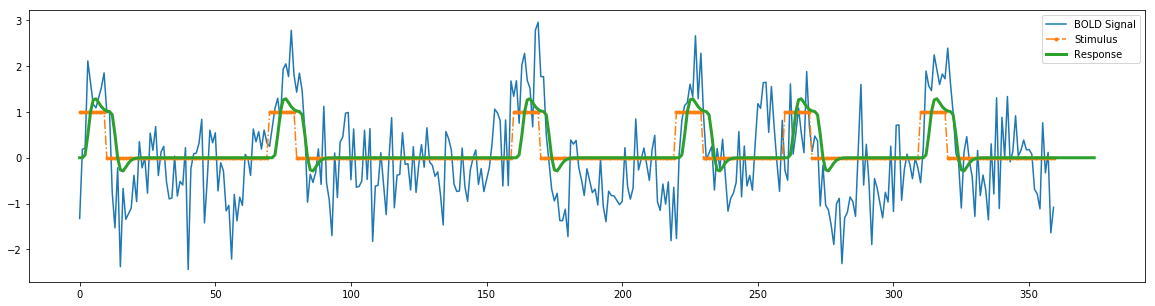

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(faces_timeseries_centered, label='BOLD Signal')
plt.plot(faces_stimulus, '.-.', label='Stimulus')
plt.plot(faces_response, lw=3, label='Response')
plt.legend()

What if we do the convolution the other way round?

In [18]:
faces_response_2 = convolution(hrf, faces_stimulus)

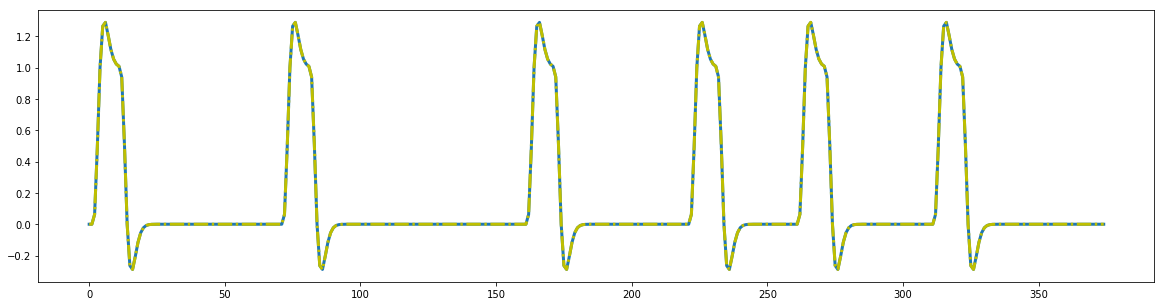

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(faces_response_2, lw=3)
plt.plot(faces_response, 'y-.', lw=3)

They are the same! It doesn't matter which parameter goes first in convolution!

We shorten the vector to have it be the same size as the stimulus:

In [20]:
faces_response = faces_response[:len(faces_stimulus)]

## Breakout session
Let's display the model time series and the data time series for a place voxel. The instructions will mimic what we have done in this lecture up to now, so you will be able to copy and paste code.

1. Set the name `place_voxel_loc` to `(10, 62, 40)`. This is the location of the place-sensitive voxel of interest
2. Use `place_voxel_loc` as above to extract the time series and call it `places_timeseries`
4. Create a name `places_stimulus` which is `True` whenever a place is shown to the subject.
5. Create `places_response` using `np.convolve` or `convolution` with `places_stimulus` and the `hrf`.
6. Shorten `places_response` to the length of the `places_stimulus` by cutting off points at the end.
6. Create a figure and plot `places_timeseries` and `places_response`.

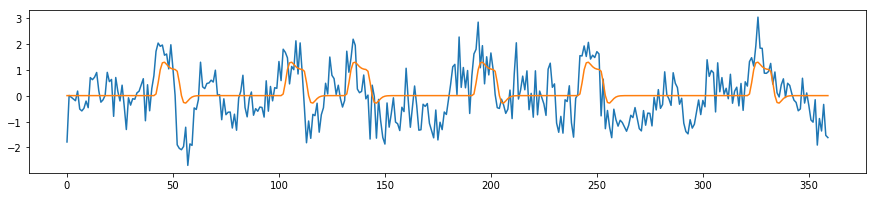

In [25]:
place_voxel_loc  =  (10, 62, 40)
z, y, x = place_voxel_loc

places_timeseries = midterm_data[:, z, y, x]
places_timeseries_centered = places_timeseries - places_timeseries.mean()
places_stimulus = category_labels == 'places'

places_response = np.convolve(places_stimulus, hrf)
places_response = places_response[:len(places_stimulus)]

fig_places = plt.figure(figsize=(15, 3))
plt.plot(places_timeseries_centered)
plt.plot(places_response)


# Temporal Normalization (Z-Score)

Now that we know how to make a response vector that is a good prediction of what the BOLD signal would look like when responding to a given stimulus (or task) type, we want to quantify how well that response vector characterizes the BOLD signal with numbers. To do this we're going to use correlation. From one perspective, the first step in correlation is to z-score both the response vector and the BOLD signal data. Let's learn about temporal normalization and z-scoring before we dive into correlation

## Definitions
Within statistics and signal processing the term **normalization** refers to a number of different computations that "adjust values measured on different scales to a notionally common scale". That "notionally common scale" can be the range between zero and one, for example, meaning the maximum value in the data becomes `1` and the minimum value in the data becomes `0`. **Normalization** is done for a number of reasons ranging from simply making data more interpretable, to removing irrelevant differences in signals to allow for their joint analyses. For more on **normalization** see <a href="https://en.wikipedia.org/wiki/Normalization_(statistics)">here</a>.

**Temporal normalization** is simply the process of normalization applied to data in the time domain. In the case of fMRI, that means normalizing each voxel time series, across all the runs of a subject so they are on the same scale. 

We'll cover two types of **normalization** today:

1\. **Feature Scaling:** Puts all the data into the range [0-1] (the brackets mean inclusive). <br/>Formula:

\begin{align}
X^{\prime} & = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}
where $X^{\prime}$ is the feature scaled data, $X$ is the original data, $X_{min}$ is the minimum value of the data, and $X_{max}$ is the maximum value of the data.

2\. **Standard Scoring (Z-Scoring):** Makes the mean of the data equal `0` and the standard deviation of the data equal `1`. <br/>Formula:
\begin{align}
Z & = \frac{X - \mu}{\sigma}
\end{align}
where $X$ is the data, $\mu$ is the mean of the data, and $\sigma$ is the **standard deviation** of the data.

Let's get familiar with **normalization** by exploring **feature scaling** one step at a time.

## Feature Scaling

Feature scaling is perhaps the simplest form of **normalization**, and is conceptually easy to understand. The idea is to move all of the data to a known range, in this case from [0-1]. Let's create a toy array of random data to practice with, then plot it. 

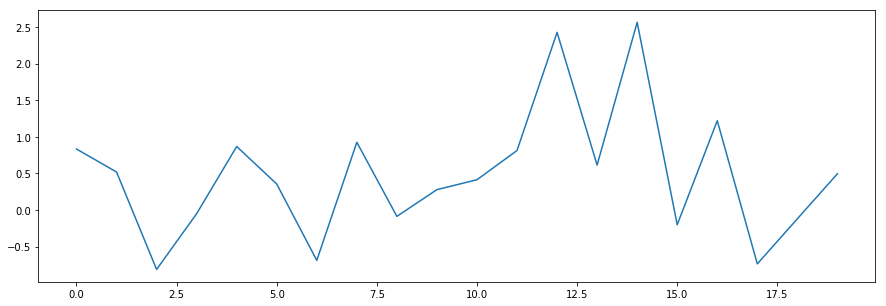

In [26]:
array_random = np.random.randn(20)
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random)

The first step of **feature scaling** is to remove the minimum value from the data. Let's see what that does:

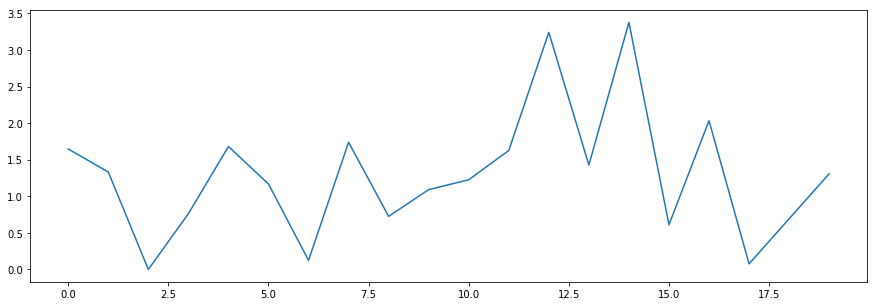

In [27]:
array_random_offset = array_random - array_random.min()
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random_offset)

Huh, the plot looks the same, so what's the difference? Removing the minimum value does not change the shape of the data, it simply **offsets** (or shifts along the y-axis) the data, making the new minimum value equal to zero. So we can see the change only in the values of the y-axis. Notice the lowest value is now `0`, when it was around `-1` before.

The second step of **feature scaling** is to divide all the data by the new maximum value. Let's do that here:

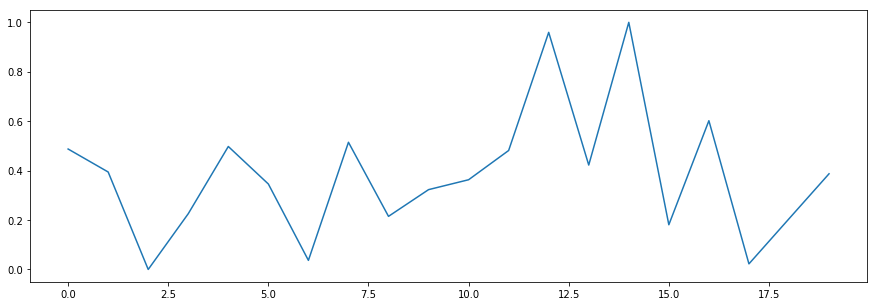

In [28]:
array_random_featurescaled = array_random_offset / array_random_offset.max()
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random_featurescaled)

What changed this time? Again, the plot looks the same, only the scale of the data (on the y-axis) has changed. By dividing the offset data by it's new max value, we've **scaled** the data so it's new maximum is `1`. That's true because dividing a number by itself always equals one, so dividing all the numbers by the maximum means the new maximum has to be `1`. Also, since the new minimum was `0`, dividing `0` by any number always returns zero. So now our data is guaranteed to be within the range [0-1]!

Important to note is that **normalization** does not change the "shape" of your time series - it simply applies an **offset**, and then **scales** the data.

We can combine both the offset and scaling into a single line of code for convenience. Let's remind ourselves of the equation for features scaling first:

\begin{align}
X^{\prime} & = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}

In [29]:
array_random_featurescaled2 = (array_random - array_random.min()) / (array_random.max() - array_random.min())

print(array_random_featurescaled)
print(array_random_featurescaled2)

[ 0.4873792   0.39434269  0.          0.22561469  0.4975951   0.34579415
  0.03677371  0.51465562  0.21487053  0.32297949  0.36304273  0.48140273
  0.9595121   0.42250571  1.          0.18088001  0.60198516  0.02254921
  0.20500469  0.38714881]
[ 0.4873792   0.39434269  0.          0.22561469  0.4975951   0.34579415
  0.03677371  0.51465562  0.21487053  0.32297949  0.36304273  0.48140273
  0.9595121   0.42250571  1.          0.18088001  0.60198516  0.02254921
  0.20500469  0.38714881]


The values from both ways of feature scaling look the same, but the code this new way looks a little different than when we did it the first time. That's because in the first way we did it, we used the maximum value from the array that already had the minimum removed. Since the new way uses the original `array_random` everywhere, we have to remove the minimum from the maximum explicity.

#### Breakout Session

1\. Create a helper function to do feature scaling. Call the function `feature_scaling_simple`. It will have a single argument, the array to feature scale called `data`, and will return the feature scaled array. 

In [30]:
def feature_scaling_simple(data):
    return (data - data.min()) / (data.max() - data.min())

2\. Now update the function you just created by adding a second argument that designates which axis the feature scaling should be done across. Call the second argument `dim` and make it default to `0`, and call the function `feature_scaling`.

In [31]:
def feature_scaling(data, dim=0):
    return (data - data.min(axis=dim)) / (data.max(axis=dim) - data.min(axis=dim))

3\. Finally, create a 2-D array of random numbers with shape `(4,8)`, call it `array_random2D`. Now use the two versions of the feature scaling function on it. Do you expect the same answer, or different answers?

In [38]:
array_random2D = np.random.randn(4, 6)
print("random array")
print(array_random2D)
print("feature scaling simple")
print(feature_scaling_simple(array_random2D))
print("feature scaling")
print(feature_scaling(array_random2D, dim=0))


random array
[[-0.93861831 -0.16907377  0.52177984  0.09963339  0.84019516 -0.67472319]
 [-1.19959711  1.81011265  0.02384984 -0.86983209 -0.26810178 -1.27026765]
 [ 0.3785156  -0.7024612  -0.20878624  0.80624897 -0.14147859 -1.26664795]
 [ 2.251837    1.35708349 -0.59096535  0.03170141  0.3113208   0.99294924]]
feature scaling simple
[[ 0.09416226  0.31265223  0.50880018  0.38894388  0.59920503  0.16908767]
 [ 0.02006486  0.87458511  0.36742732  0.11369212  0.28453609  0.        ]
 [ 0.46812444  0.16121226  0.30137702  0.58956698  0.32048709  0.00102771]
 [ 1.          0.74596055  0.19286829  0.36965655  0.44904641  0.64257514]]
feature scaling
[[ 0.0756146   0.21228726  1.          0.57841205  1.          0.26314069]
 [ 0.          1.          0.55252109  0.          0.          0.        ]
 [ 0.45723391  0.          0.34345609  1.          0.11425023  0.00159936]
 [ 1.          0.81969519  0.          0.5378818   0.52280445  1.        ]]


### An application of feature normalization: Making a floating point RGB image

Remember making a color image in a previous homework? We did this using three arrays as color channels. Let's do this again here, but let's set the image up such that the color `(0, 0, 0)` is a neutral gray, `(1, 1, 1)` is white, and `(-1, -1, -1)` is black. Any continuous value in between encodes colors.

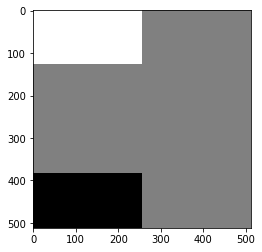

In [39]:
R = np.zeros((512, 512))
R[:128, :256] = 1
R[-128:, :256] = -1
fig_R = plt.figure()
plt.imshow(R, cmap='gray')

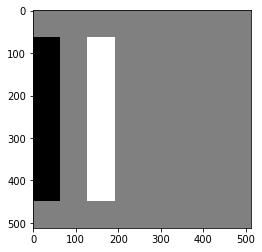

In [40]:
G = np.zeros((512, 512))
G[64:-64, 128:192] = 1
G[64:-64, :64] = -1
fig_G = plt.figure()
plt.imshow(G, cmap='gray')

In [41]:
B = np.zeros((512, 512))

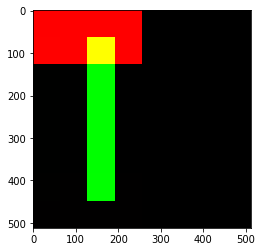

In [42]:
RGB = np.stack((R, G, B), axis=2)
fig_RGB = plt.figure()
plt.imshow(RGB)

Huh, that doesn't seem to be showing what we wanted to show!

This is because `matplotlib` has very specific ways of normalizing images to be displayed as RGB-values: If they are floats, only variation between 0 and 1 is considered valid. If they are `uint8`, then it is variation between 0 and 255 (as in the 2D array homework).

Let's use feature normalization to bring our RGB-image into the [0, 1] range:

In [43]:
RGB_normalized = feature_scaling_simple(RGB)

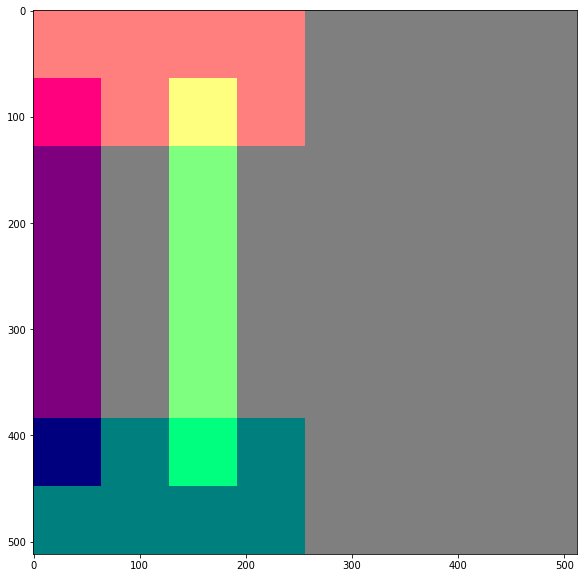

In [45]:
fig_RGB_normalized = plt.figure(figsize=(10, 10))
plt.imshow(RGB_normalized)

### Breakout Session

1. Why do the colors look subdued in this image?
2. Fill the array `B` with a rectangle that intersects some of the rectangles in the other channels. Assign to it a value of `1` for maximum blue channel. Make another rectangle with value `-1`. Re-stack the `RGB` image and re-plot the figure to take a look. Then normalize using feature scaling and plot the normalized
3. Change one pixel of any channel to the value -1000. Re-stack the RGB image, plot the output and then plot the normalized image.
4. Add another pixel with value 1000 and repeat 3.

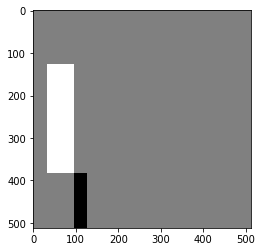

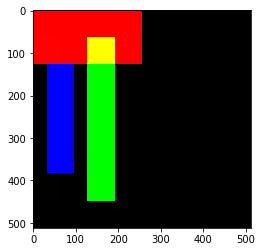

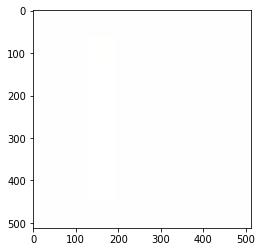

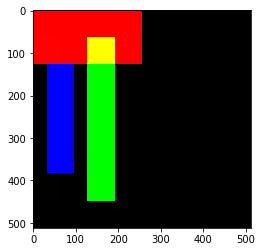

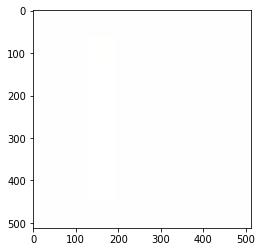

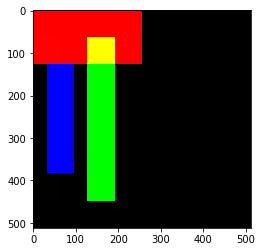

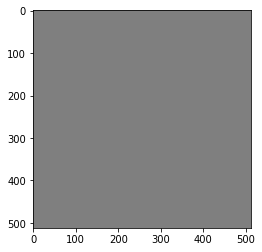

In [50]:
RGB_normalized[0, 0]

B[128:-128, 32:96] = 1
B[-128:, 96:128] = -1
plt.imshow(B, cmap='gray')
rgb = np.stack((R, G, B), axis=2)
plt.figure()
plt.imshow(rgb)
RGB_normalized = feature_scaling_simple(rgb)
plt.figure()
plt.imshow(RGB_normalized)

R[0, 0] = -1000
rgb = np.stack((R, G, B), axis=2)
plt.figure()
plt.imshow(rgb)
RGB_normalized = feature_scaling_simple(rgb)
plt.figure()
plt.imshow(RGB_normalized)

R[-1, -1] = 1000
rgb = np.stack((R, G, B), axis=2)
plt.figure()
plt.imshow(rgb)
RGB_normalized = feature_scaling_simple(rgb)
plt.figure()
plt.imshow(RGB_normalized)



## Problems with Feature Scaling

**Feature scaling** is very useful to put data into an easily interpretable scale, however a problem with this normalization method shows up when you have outlying values far way from the mean. What would happen if we add a very large outlying value at a single time point? Let's see!

In [51]:
array_random_long = np.random.randn(100)
array_random_outlier = array_random_long.copy()
array_random_outlier[80] = array_random_outlier.max()*20

To visualize what's happening in these data sets we'll use

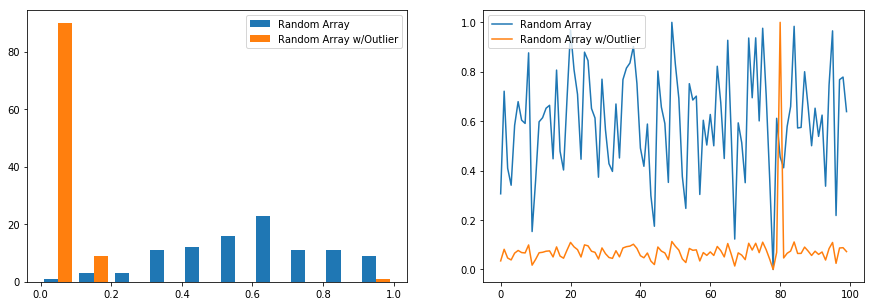

In [53]:
array_random_stacked = np.stack((feature_scaling(array_random_long), feature_scaling(array_random_outlier)), axis=1)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(array_random_stacked, 10)
_ = plt.legend(('Random Array', 'Random Array w/Outlier'))
plt.subplot(1,2,2)
plt.plot(array_random_stacked)
_ = plt.legend(('Random Array', 'Random Array w/Outlier'))


Looking at the histogram, the array with the outlier has most of its data lying in a single bin of the histogram. Feature scaling does not put the data from both arrays into a similar range, because the max value is not stable (it can change a lot depending on only one data point). As we've learned, (linear) data normalization involves an *offset* operation (by subtracting off some value) and a **scaling** operation (by dividing by some value or performing some nonlinear operation). 

A more robust and stable way to normalize data is to subtract the **mean** of the data instead of the min, and to divide by the **standard deviation** instead of the range (max - min). This is exactly what z-scoring does. Let's learn more about it now.

## Standard Scoring (Z-Scoring)

One of the most commonly used forms of **normalization** is to create standard scores, or z-scores. A z-scored dataset has a mean of 0, and a standard deviation of 1. So what's a standard deviation? Let's find out.

### Standard Deviation

**Standard deviation** is a descriptive statistic that measures the average distance away from the mean (in either direction) of a data set. When a data set has a small standard deviation, the data points tend to be close to the mean, when the standard deviation is large the data points tend to be far from the mean. 

Before we jump into the equation for the standard deviation, let's get a visual intuition for what the standard deviation looks like by plotting the distribution of some random Gaussian data. We learned earlier today that `np.random.randn` actually gives us **standard normal** data, whose **distribution** is Gaussian (shaped like the Bell curve), and whose mean is `0` and standard deviation is `1`. We'll plot the data using a histogram, since that plots the **distribution** of the data. Then we'll draw a line for the mean, and two lines for standard deviation on either side of the mean. 

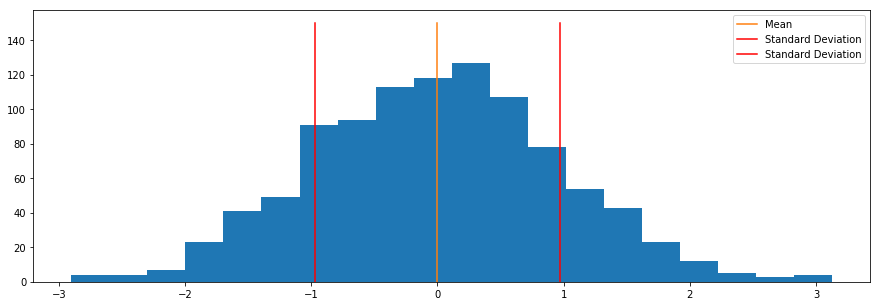

In [54]:
data_stddev = np.random.randn(1000)
fig = plt.figure(figsize=(15,5))
_ = plt.hist(data_stddev, bins=20)
_ = plt.plot([data_stddev.mean(), data_stddev.mean()], [0,150], label='Mean')
_ = plt.plot([-data_stddev.std(), -data_stddev.std()], [0,150], 'r', label='Standard Deviation')
_ = plt.plot([data_stddev.std(), data_stddev.std()], [0,150], 'r', label='Standard Deviation')
_ = plt.legend()

Now let's look at how to calculate the standard deviation. The formula is a bit complicated-looking, but we'll work through it step by step to see it's actually not that bad.

$$\hat{\sigma} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \overline{x})^2}$$

where $\hat{\sigma}$ is the estimated standard deviation, $N$ is the number of samples in your data set, $x_i$ is the ith data point, and $\overline{x}$ is the mean of the data set.

When tryring to understand a formula, it can be useful to pick it apart starting with the innermost calculation, and work outwards. Let's do that here, starting with:
$$\sum_{i=1}^N (x_i - \overline{x})^2$$

That Greek letter ($\sum$) is an uppercase "sigma" and stands for the `sum` operation. In this case it means to sum all that's in the parentheses, across all the $x_i$ values. So this expression is saying, for each data point:
1. Subtract the mean
2. Square that difference

And then sum all those squared differences. This sum is calculated many places in statistics, and is called the **sum of squared differences**, or **sum of squares** for short. Let's do that here:

In [55]:
x = array_random
differences = x - x.mean()
differences_squared = differences**2
sum_squares = differences_squared.sum()
sum_squares

15.305758889981711

Or we can put that all into a single line of code like this:

In [56]:
sum_squares = np.sum((x - x.mean())**2)

That was really the hard part! Now we take that value, divide it by $N$, and take the square root:

In [57]:
N = x.shape[0]
std_dev = np.sqrt(sum_squares / N)
std_dev

0.87480737565425537

The standard deviation is such a common operation that there is a function for it, `std`. Let's verify we got the same answer as the numpy function:

In [58]:
x.std()

0.87480737565425537

#### Breakout Session
1\. Remember when we computed the SNR of a brain scan? Let's look back at the function we used to calculate noise in a volume. Describe the 3 calculations this function makes to calculate the noise.

In [ ]:
def calc_noise(data):
    
    # determine the voxels that are outside the brain, 
    # assuming their value is around 300 in the first volume
    outside_brain_mask = data[0] <= 300
    
    # get all the voxels that are not in the brain, for each time point
    outside_brain_vox = data[:,outside_brain_mask]
    
    # find the standard deviation of the voxels outside the brain, for
    # each volume across time
    data_std = np.std(outside_brain_vox, axis=0)
    
    # take the average of all of those standard deviations
    noise = np.mean(data_std)
    return noise

### Creating Z-Scores

Now that we know what a standard deviation is, we can calculate z-scores. Remember that z-scoring makes the mean of the data `0`, and the standard deviation of the data `1`. To do that we'll use the same logic as we did with **feature scaling**. To make the mean zero, we'll **offset** (or subtract) the data by the mean. Then to make the standard deviation `1`, we'll divide that by the standard deviation. Here's the equation, which is actually very simple:

\begin{align}
Z & = \frac{X - \mu}{\sigma}
\end{align}

Let's create z-scores from the original array of random data `array_random` here:

In [59]:
array_random_zscore = (array_random - array_random.mean()) / array_random.std()
array_random_zscore

array([ 0.40229183,  0.04302163, -1.47977383, -0.60853914,  0.44174159,
       -0.14445362, -1.33776831,  0.50762261, -0.65002885, -0.23255478,
       -0.07784642,  0.37921307,  2.22548234,  0.15177611,  2.3818306 ,
       -0.78128677,  0.84485472, -1.39269769, -0.68812682,  0.01524172])

There is also a function to do z-scoring for us already in python, it is called `zscore` and is in the module `scipy.stats`. Let's import it and use it to verify that our answer is correct. 

In [60]:
from scipy.stats import zscore
array_random_zscore2 = zscore(array_random, axis=0)
print(array_random_zscore)
print(array_random_zscore2)

[ 0.40229183  0.04302163 -1.47977383 -0.60853914  0.44174159 -0.14445362
 -1.33776831  0.50762261 -0.65002885 -0.23255478 -0.07784642  0.37921307
  2.22548234  0.15177611  2.3818306  -0.78128677  0.84485472 -1.39269769
 -0.68812682  0.01524172]
[ 0.40229183  0.04302163 -1.47977383 -0.60853914  0.44174159 -0.14445362
 -1.33776831  0.50762261 -0.65002885 -0.23255478 -0.07784642  0.37921307
  2.22548234  0.15177611  2.3818306  -0.78128677  0.84485472 -1.39269769
 -0.68812682  0.01524172]


Yup, we did it right!

Now let's see how z-scoring changed the data by creating line plots like we did when **norming** (doing normalization) with **feature scaling** above.

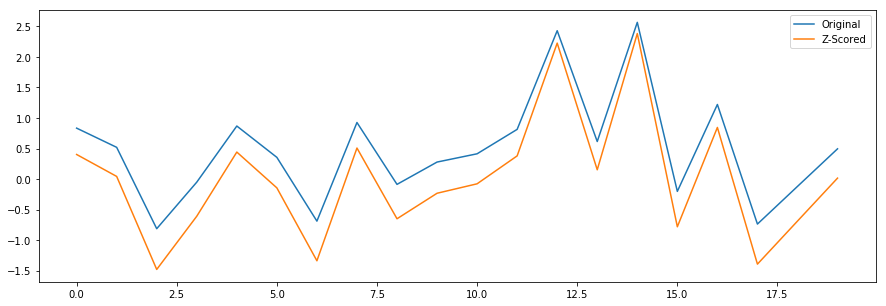

In [61]:
fig = plt.figure(figsize=(15,5))
_= plt.plot(array_random, label='Original')
_= plt.plot(array_random_zscore, label='Z-Scored')
_ = plt.legend()

Since the random data array we created was actualy drawn from a **standard normal** distribution its mean was already almost `0` and its standard deviation almost `1`, so z-scoring didn't change things that much here! Let's move on to some real fMRI data where that won't be the case.

#### Breakout session

1\. Z-score the 2-D `array_random2D` along the first axis (meaning z-score each column indepependently), and do the calculations manually (don't use the `zscore` function).

### Z-Scoring fMRI data

We've learned that values recorded by fMRI data is recorded in arbitrary units, and about issues such as **scanner drift**. For both of these reasons, and others, the raw values of fMRI BOLD data can vary drastically between different runs on the same subject in the same day. Another way to say this, is that we're really just concerned with relative differences in the BOLD signal, and not the absolute differences. **Temporal normalization** is often used to remove these meaningless differences is signal between scans of the same subject. Z-scoring is the most common form of this.

Let's load 2 more scans worth of data from this subject in order to practice z-scoring with:

In [62]:
img1 = nibabel.load("/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz")
data1 = img1.get_data().T
img2 = nibabel.load("/data/cogneuro/fMRI/categories/s01_categories_02.nii.gz")
data2 = img2.get_data().T
img3 = nibabel.load("/data/cogneuro/fMRI/categories/s01_categories_03.nii.gz")
data3 = img3.get_data().T

To illustrate z-scoring on real fMRI data we'll extract a single voxel time series from all 3 scans. 

In [63]:
timeseries1 = data1[:, 6, 57, 37]
timeseries2 = data2[:, 6, 57, 37]
timeseries3 = data3[:, 6, 57, 37]
timeseries3.shape

(120,)

Now we will contatenate these time series together to have a lot of data for analysis. We'll use `np.concatenate` to make a single 1-D array of the 3 time series in a row.

In [64]:
timeseries_total = np.concatenate((timeseries1, timeseries2, timeseries3), axis=0)
timeseries_total.shape

(360,)

Before we start the z-scoring process, let's plot the data to see why we need to z-score in the first place.

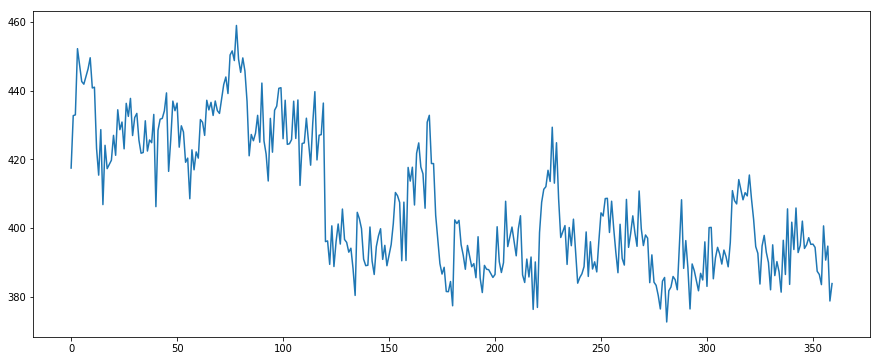

In [65]:
plt.figure(figsize=(15, 6))
_ = plt.plot(timeseries_total)

The signals of each run seem to vary around very different mean values! Let's visualize this by drawing some lines into the plot that represent the mean of the 3 scans.

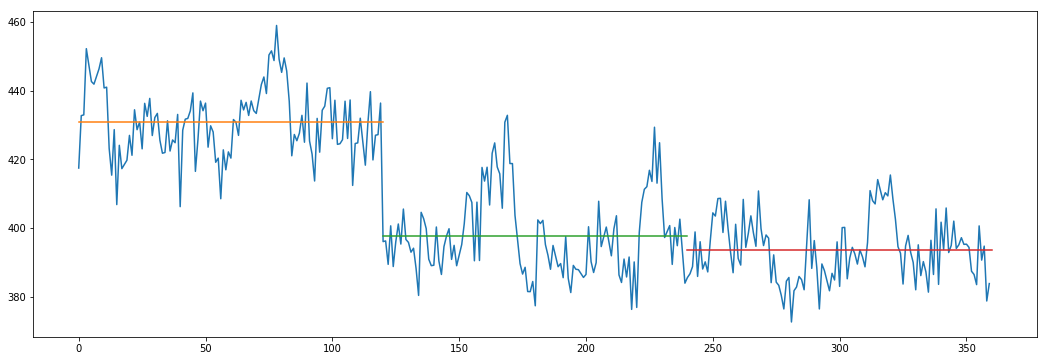

In [66]:
plt.figure(figsize=(18, 6))
plt.plot(timeseries_total)
mean1 = timeseries1.mean()
mean2 = timeseries2.mean()
mean3 = timeseries3.mean()
timeseries_len = timeseries1.shape[0]
plt.plot([0, timeseries_len], [mean1, mean1])
plt.plot([timeseries_len, timeseries_len * 2], [mean2, mean2])
_ = plt.plot([timeseries_len * 2, timeseries_len * 3], [mean3, mean3])

Now let's take the first stage of z-scoring, to subtract the mean. We'll be z-scoring each timeseries separately, so we'll subtract the mean of each timeseries separately here.

In [67]:
timeseries1_centered = timeseries1 - mean1
timeseries2_centered = timeseries2 - mean2
timeseries3_centered = timeseries3 - mean3
timeseries_total_centered = np.concatenate((timeseries1_centered, timeseries2_centered, timeseries3_centered))

Now let's plot the total time series with the means removed from the 3 time series.

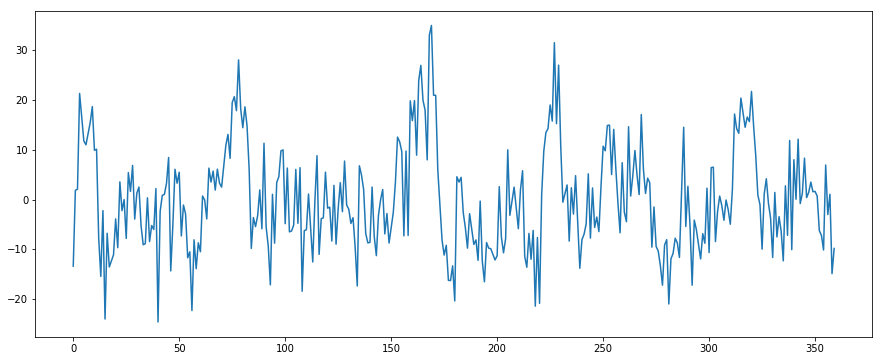

In [68]:
plt.figure(figsize=(15, 6))
_ = plt.plot(timeseries_total_centered)

The total time series now looks a lot more similar. There could still be differences in the average amount of difference from the means (which is the standard deviation!), however. Let's calculate the standard deviations and plot them using colored strips that center on the mean. We'll use a different color for each scan.

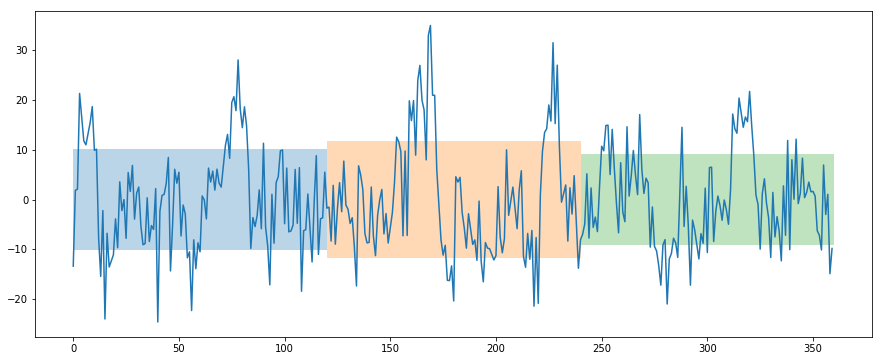

In [69]:
stdev1 = np.std(timeseries1_centered)
stdev2 = np.std(timeseries2_centered)
stdev3 = np.std(timeseries3_centered)

plt.figure(figsize=(15, 6))
plt.plot(timeseries_total_centered)
plt.fill_between([0, timeseries_len], [-stdev1, -stdev1], [stdev1, stdev1], alpha=.3)
plt.fill_between([timeseries_len, timeseries_len*2], [-stdev2, -stdev2], [stdev2, stdev2], alpha=.3)
_ = plt.fill_between([timeseries_len*2, timeseries_len*3], [-stdev3, -stdev3], [stdev3, stdev3], alpha=.3)

We can see the heights of the 3 colored strips are different, which indicates the standard deviation differs across the 3 runs. Let's complete the z-scoring process and divide each scan's time series by the standard deviation, separately.

In [70]:
timeseries1_zscored = timeseries1_centered / stdev1
timeseries2_zscored = timeseries2_centered / stdev2
timeseries3_zscored = timeseries3_centered / stdev3
timeseries_total_zscored = np.concatenate((timeseries1_zscored, timeseries2_zscored, timeseries3_zscored))

And finally we'll plot the z-scored time series along with the original concatonated time series so we can see how z-scoring changed the values.

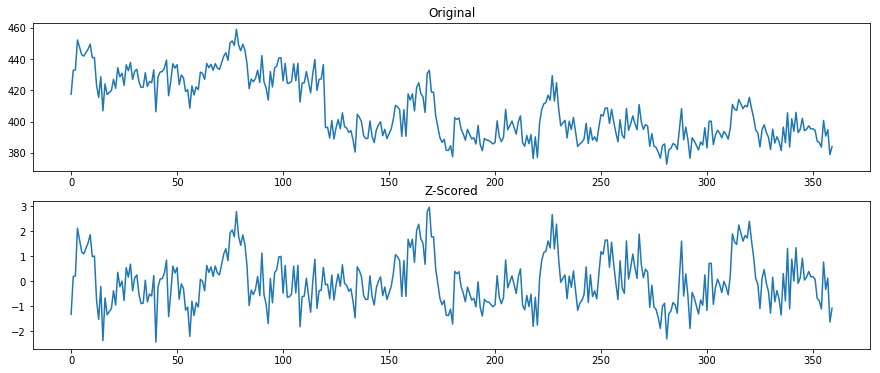

In [71]:
plt.figure(figsize=(15, 6))
plt.subplot(2,1,1)
_ = plt.plot(timeseries_total)
_ = plt.title('Original')
plt.subplot(2,1,2)
_ = plt.plot(timeseries_total_zscored)
_ = plt.title('Z-Scored')

### Breakout Session
Do the same thing with the voxel in the location `places_voxel_loc`
1. Extract `places_timeseries1` to `places_timeseries3` from `data1, data2, data3`
2. Concatenate them and plot them
3. Compute the means and plot the means as straight lines from 0 to 120, 120 to 240, and 240 to 360.
4. Center each places time series, concatenate them and plot them
5. Compute the standard deviations, and plot two lines, one above, one below the mean at the distance of the standard deviation
6. Zscore each places time series, concatenate them and plot them 

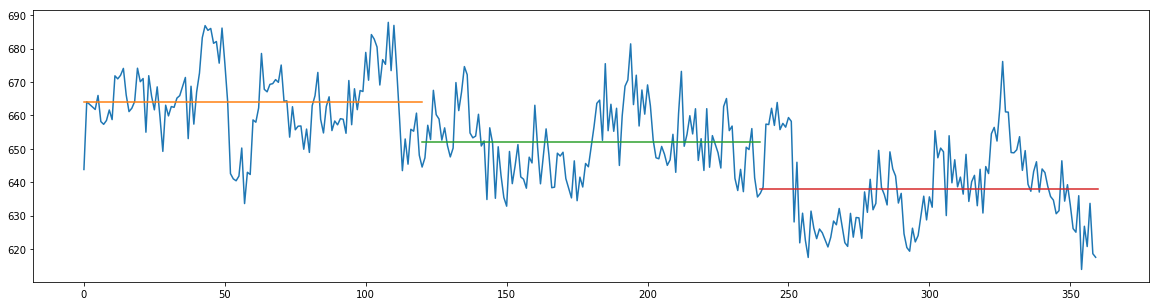

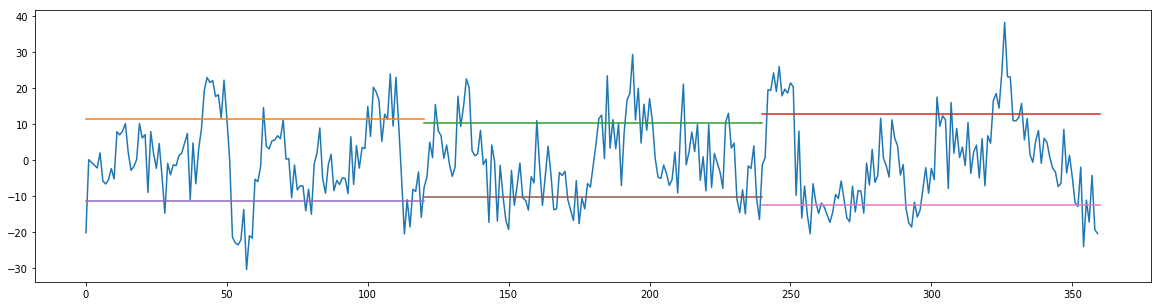

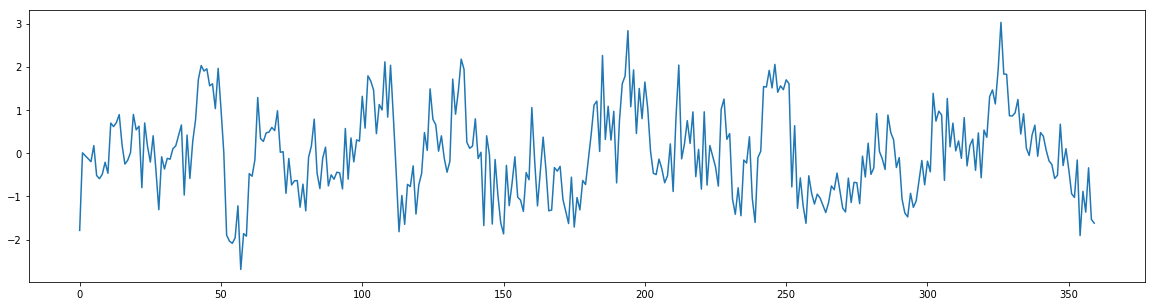

In [119]:
z, y, x = place_voxel_loc
places_timeseries1 = data1[:, z, y, x]
places_timeseries2 = data2[:, z, y, x]
places_timeseries3 = data3[:, z, y, x]

places_timeseries = np.concatenate([places_timeseries1, places_timeseries2, places_timeseries3])
plt.figure(figsize=(20, 5))
plt.plot(places_timeseries)

mean1 = places_timeseries1.mean()
mean2 = places_timeseries2.mean()
mean3 = places_timeseries3.mean()

plt.plot([0, 120], [mean1, mean1])
plt.plot([120, 240], [mean2, mean2])
plt.plot([240, 360], [mean3, mean3])

places_timeseries1_centered = places_timeseries1 - mean1
places_timeseries2_centered = places_timeseries2 - mean2
places_timeseries3_centered = places_timeseries3 - mean3

places_timeseries_centered = np.concatenate([places_timeseries1_centered, places_timeseries2_centered, 
                                              places_timeseries3_centered
                                             ])
plt.figure(figsize=(20, 5))
plt.plot(places_timeseries_centered)

stdev1 = places_timeseries1.std()
stdev2 = places_timeseries2.std()
stdev3 = places_timeseries3.std()

plt.plot([0, 120], [stdev1, stdev1])
plt.plot([120, 240], [stdev2, stdev2])
plt.plot([240, 360], [stdev3, stdev3])

plt.plot([0, 120], [-stdev1, -stdev1])
plt.plot([120, 240], [-stdev2, -stdev2])
plt.plot([240, 360], [-stdev3, -stdev3])

places_timeseries1_zscored = places_timeseries1_centered / stdev1
places_timeseries2_zscored= places_timeseries2_centered / stdev2
places_timeseries3_zscored = places_timeseries3_centered / stdev3

places_timeseries_zscored = np.concatenate([places_timeseries1_zscored,
                                           places_timeseries2_zscored,
                                           places_timeseries3_zscored])
plt.figure(figsize=(20, 5))
plt.plot(places_timeseries_zscored)

# Correlation

With our understanding of z-scoring in hand we can move on to correlation, which is a technique that we will use to quantify the similarity between the response vector and the actual BOLD data. Remember that the response vector is our best guess as to how the brain will respond to the stimuli or tasks the participant is exposed to. So when we find a high correlation between response and BOLD vectors in a certain region of the brain, we can infer that this region's neurons fire in response to the stimulus or task. So what is correlation? 

Correlation is a statistic calculated on two variables that ranges from [-1,1] and indicates how similar the data in the two vectors are. There are multiple ways to think about it what it actually does, and here are 3 good ways to think about it:
* Correlation is the slope of a line that best reduces the squared error between z-scored data in a scatter plot.
* Correlation measures the extent to which two variables change together away from their respective means. 
* Correlation is the average product of the standardized scores of two variables.

We'll now see these 3 ways of thinking about correlation, so that we can apply correlation to the visual category experiment we saw last lecture. The first definition above is the most common way to understand correlation, so we'll start there.

## Correlation 1: as a line reducing error on a scatter plot.

Plotting data on a scatter plot lets us look at the relationship between two vectors of data. If we z-score both of those vectors then there are both centered on zero, and on the same scale (where every unit is standard deviation of the data). Looking at the scatter plot, we can quantify how much changes in the first vector affect changes in the second vector by drawing a line between the data points that is, on average, closest to all the data in the y-axis. The slope of this line then tells us how much the data in the second vector changes for every unit change in the first vector. And since both vectors are z-scored, it's guaranteed that the slope of this line will be between [-1,1]. Let's find out exactly what a scatter plot is and why this is true.

### Scatter plots 

A scatter plot is a visualization technique that plots the value of each data point in two different vectors, such as height and weight. It allows you to see the relationship between the two variables because it shows you how the data changes in one variable as the other variable changes. A scatterplot shows us the relationship between the data in the two vectors. If we see that the y-axis values vary with the x-axis values, then we can conclude some statistical dependence (but not causation!) between the two vectors.

A one-colored scatterplot can be created by using the `plt.plot` function you already know, simply by specifying a marker that is a point (and not a line) in the format string after the data. Point markers can be `x, ., o, +, ^`, and others. 

We'll illustrate that here using some fake data first. We'll think of this data as reprsenting the height and weight of a random sample of people, and assume the mean weight is 150lbs with a standard deviation of 20lbs, and the mean height is 66 inches (5'6") with a standard deviation of 3 inches.

In [120]:
weight = np.random.randn((100))*20 + 150
height_random = np.random.randn((100))*3 + 66

Now let's plot both of these in a scatter plot.

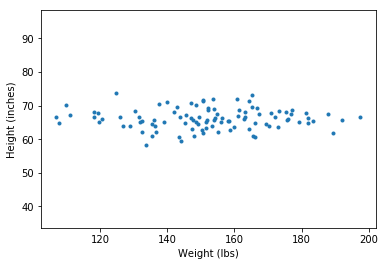

In [123]:
plt.plot(weight, height_random, '.')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
_ = plt.axis('equal')

To be more explicit, you can also use `marker='x', linestyle=''` to the same effect.

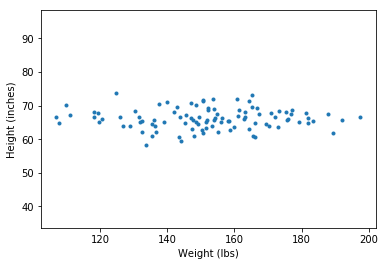

In [124]:
plt.plot(weight, height_random, marker='.', linestyle='')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
_ = plt.axis('equal')

So how do we interpret this plot? Each dot represents one data point in both the weight and height vectors. By data point, we mean that the index into both vectors is the same. So there's a single dot that represents the `0` index into the height and weight vectors, and that dot is plotted in the x-axis (horizontal) direction based on it's value in the `weight` vector, and it's y-axis (vertical) direction is based on it's value in the `height` vector. 

We are looking for a trend among all the data points, such that when the `weight` value increases, the `height` value seems to increase (or decrease) in a consistant manner across the data points.  This data looks somewhat circular, which is an indication that there is no relationship between the `weight` and `height` vectors.

What would happen if created a scatter plot of the `weight` vector plotted against itself? Let's see

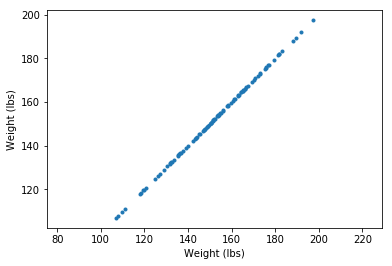

In [125]:
plt.plot(weight, weight, marker='.', linestyle='')
plt.xlabel('Weight (lbs)')
plt.ylabel('Weight (lbs)')
_ = plt.axis('equal')

It's a straight line! When two vectors have a perfect **linear relationship**, then they form a perfect straight line when plotted in a scatter plot. Any vector will always have a perfect **linear relationship** with itself, because it always moves together! Quantifying how close to a line two vectors are is one way of thinking about correlation. Let's see how that works with more complicated data now.

### Breakout Session
Let's find something in between "no correlation" and "perfect correlation". To do this, we'll take the `weight` vector from above, and add some noise, and plot it against the original `weight` vector in a scatter plot

1. Set `noise_level` to 2
2. Using `np.random.randn` make a vector of random values of the same shape as `weight`, and multiply it by `noise_level`. Store the result in `noise`
3. Add `noise` to `weight` and call it `weight_noisy`
4. Make a scatterplot of `weight` and `weight_noisy`
5. Modify `noise_level` and redo the scatter plot. Observe the results.

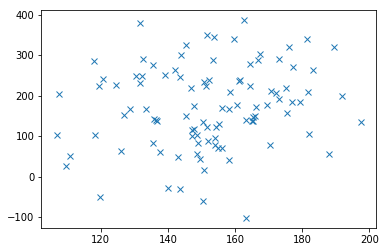

In [129]:
noise_level = 100

noise = np.random.randn(weight.shape[0]) * noise_level
weight_noisy = weight + noise
plt.plot(weight, weight_noisy, 'x')

### Scatter Plot Lines in Simulated Data 

Let's update the weight vs height example from above, but this time we'll create a **linear relationship** between them. We'll also add some **noise** to the relationship, meaning that when `weight` increases, `height` increases, but not perfectly. What would that look like?

First we'll recreate the `height` data so that there is now a linear relationship between `weight` and `height`. To do this we'll use the formala for linear relationship that you learned in algebra class: 

$$y = ax + b$$ 

where $y$ is `height` and $x$ is `weight` and $a$ represents the how much $y$ changes for every unit change in $x$, and $b$ represents how much bigger $y$ is than $x$ when $x$ equals `0`. Let's pick $a=(3/20)$ and $b=44$ so that we keep the same mean and standard deviation for `height` as we had before.

In [131]:
height = (3/20) * weight + 44
height.mean(), weight.mean()

(66.802677862730704, 152.01785241820454)

Now we'll use a scatter plot to show what this relationship looks like.

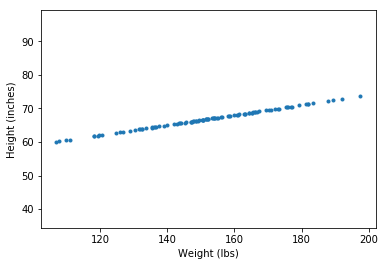

In [132]:
plt.plot(weight, height, '.')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
_ = plt.axis('equal')

This is a straight line, and we learned above that when two variables are perfectly linearly related they will have a straight line scatter plot. We also know that a perfect increasing correlation results in a correlation coefficient of `1`. Let's see what the correlation coefficient for this relationship is by using the numpy function `np.corrcoef`. 

In [133]:
corr_weight_height = np.corrcoef(weight, height)
corr_weight_height

array([[ 1.,  1.],
       [ 1.,  1.]])

The top left and bottom right values of the 2x2 matrix above show the correlations of each vector with itself (and so will always be 1). The top right and bottom left values show the correlation of weight with height, and height with weight, respectively. Since the order doesn't matter for correlation, these two values will always be equal as well. 

So we see that the correlation between `weight` and `height` is indeed perfect, with a value of 1. In general, if a scatterplot is a line that is not perfectly horizontal, then this means that the variables perfectly correlate.

Now let's add some noise so the relationship isn't perfect and we can see what a correlation other than zero looks like. The noise will have a mean of zero and a standard deviation of `2`.

In [134]:
height_noisy = height + np.random.randn(len(height)) * 2

Now let's plot this data and see what it looks like.

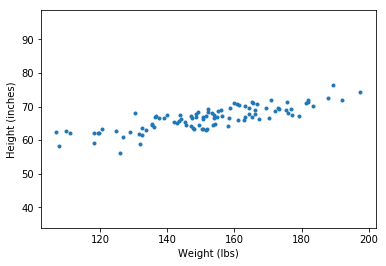

In [135]:
plt.plot(weight, height_noisy, '.')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
_ = plt.axis('equal')

It's not a straight line, but there is still an upward trend, meaning that as the values of weight increase, so do the values of height. Let's quantify this with a correlation coefficient.

In [136]:
corr_weight_height_noisy = np.corrcoef(weight, height_noisy)
corr_weight_height_noisy

array([[ 1.        ,  0.82161621],
       [ 0.82161621,  1.        ]])

Now the correlation has dropped from `1` to `0.8678`. That's still a high correlation value, but it's no longer perfect. 

### Breakout Session
Take the example from just above, vary the noise and evaluate the correlation coefficient

## Scatter Plots with Raw vs. Z-Scored Data

We've been making scatter plots using "raw" values, meaning the original data in it's original units (pounds and inches in this example). **Scatter plots of "raw" values show a perfect correlation when the data form a non-horizontal line**.

In the definition of correlation we gave above, we said that the scatter plot should show z-scored data, not raw data. If we z-score the 2 vectors before making a scatter plot, the rule for what constitutes a perfect correlation changes! Let's z-score our weight and height vectors and have a look:

In [137]:
weight_z = scipy.stats.zscore(weight)
height_z = scipy.stats.zscore(height)

Now we'll plot them on a scatter plot:

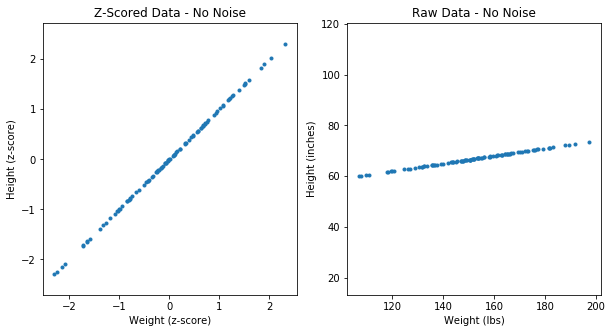

In [138]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(weight_z, height_z, '.')
plt.xlabel('Weight (z-score)')
plt.ylabel('Height (z-score)')
plt.title('Z-Scored Data - No Noise')
_ = plt.axis('equal')
plt.subplot(1,2,2)
plt.plot(weight, height, '.')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
plt.title('Raw Data - No Noise')
_ = plt.axis('equal')

Notice that the slope of the line has changed when the data is z-scored! This is because both height and weight are on the same scale (standard deviations). 

Now let's z-score the noisy data and plot it vs the weight data.

In [139]:
height_noisy_z = scipy.stats.zscore(height_noisy)

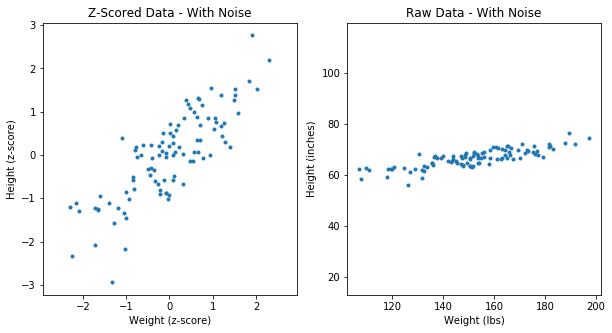

In [140]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(weight_z, height_noisy_z, '.')
plt.xlabel('Weight (z-score)')
plt.ylabel('Height (z-score)')
plt.title('Z-Scored Data - With Noise')
_ = plt.axis('equal')
plt.subplot(1,2,2)
plt.plot(weight, height_noisy, '.')
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (inches)')
plt.title('Raw Data - With Noise')
_ = plt.axis('equal')

Again, notice that the slope of the data has changed, for the same reason.

So how do we interpret a scatter plot for correlation when the data is z-scored? **Perfect correlation happens when all points lie on the diagonal (slope=1) after z-scoring!** Also, the line for z-scored data will always go through the origin (the 0,0 point) since the data of both vectors have means of `0`.

So correlation is perfect when:
* **Raw data:** When the data forms a straight line, no matter what the slope of that line is. This is because the units for the two vectors can be different, and the slope is relative to the units.
* **Z-Scored data:** When the data forms a stright line with a slope of 1 (45 degree line). This is because the units are now the same, so the slope has to be 1 when the correlation is perfect.

Let's draw create a second set of noisy data with even more noise.

In [141]:
height_noisy2 = height + np.random.randn(len(height)) * 10

And find the correlation again:

In [142]:
corr_weight_height_noisy2 = np.corrcoef(weight, height_noisy2)
corr_weight_height_noisy2

array([[ 1.        ,  0.36179467],
       [ 0.36179467,  1.        ]])

And z-score this new noisier data

In [143]:
height_noisy2_z = scipy.stats.zscore(height_noisy2)

Finally let's plot the 3 z-scored relationships between weight and the 3 height values.

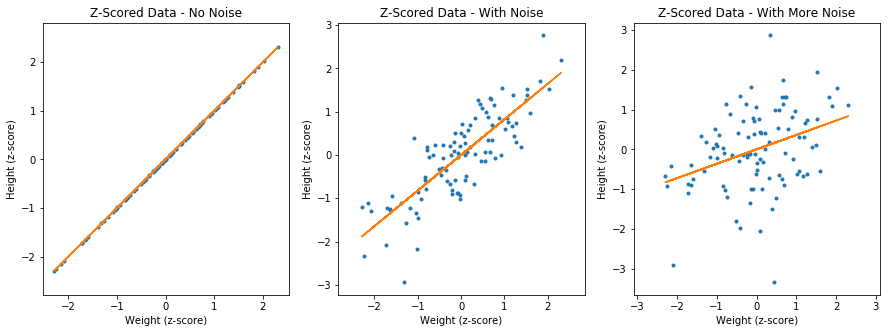

In [144]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(weight_z, height_z, '.')
plt.plot(weight_z, weight_z*corr_weight_height[0,1],)
plt.xlabel('Weight (z-score)')
plt.ylabel('Height (z-score)')
plt.title('Z-Scored Data - No Noise')
_ = plt.axis('equal')
plt.subplot(1,3,2)
plt.plot(weight_z, height_noisy_z, '.')
plt.plot(weight_z, weight_z*corr_weight_height_noisy[0,1],)
plt.xlabel('Weight (z-score)')
plt.ylabel('Height (z-score)')
plt.title('Z-Scored Data - With Noise')
_ = plt.axis('equal')
plt.subplot(1,3,3)
plt.plot(weight_z, height_noisy2_z, '.')
plt.plot(weight_z, weight_z*corr_weight_height_noisy2[0,1],)
plt.xlabel('Weight (z-score)')
plt.ylabel('Height (z-score)')
plt.title('Z-Scored Data - With More Noise')
_ = plt.axis('equal')

It does seem like these lines fit our z-scored point clouds pretty well!

### Breakout Session
Let's look at negative correlations: Take `height_noisy_z` and flip the sign of all the values (make negative values positive, and positive values negative). Call the output `height_noisy_z_sign_flipped`. Compute the correlation with `weight`, make the scatter plot and the line plot as above.

### Scatter plots of real fMRI data
Now let's make some scatter plots of the real fMRI data we've been working with.

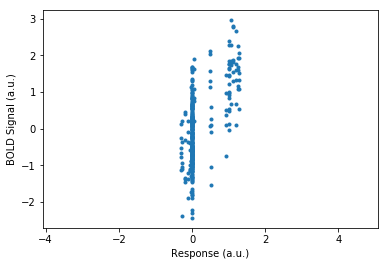

In [145]:
plt.plot(faces_response, faces_timeseries_centered, '.')
plt.xlabel('Response (a.u.)')
plt.ylabel('BOLD Signal (a.u.)')
_ = plt.axis('equal')

It looks like there is a positive relationship between the response and the BOLD signal. The data seems to fall in vertical lines. This is because the response vector only takes on a few different values due to the HRF only having 16 values.

Now let's quantify how similar they are:

In [146]:
np.corrcoef(faces_response, faces_timeseries_centered)

array([[ 1.        ,  0.61821455],
       [ 0.61821455,  1.        ]])

That's a very high correlation for fMRI data that is so noisy! 

## Breakout session

1. Put the places voxel time series and the places convolved model into one scatter plot.
2. Compute their correlation coefficient

## Correlation 2: Signals Changing Together Relative to their Means

Scatterplots are just one way to plot two z-scored variables together to inerpret their correlation. Since here we are working with *time series* vectors, we can also plot the response and BOLD signal time series data as line plots to see how similarily they change together over time, relative to their means.

We're familiar with plotting the response and BOLD signal time series together on the same plot, but we've never plotted them together after z-scoring both. Let's see how both the centering and scaling steps of z-scoring change the perceived relationship.

In [147]:
faces_response_centered = faces_response - faces_response.mean()
faces_response_zscored = scipy.stats.zscore(faces_response)

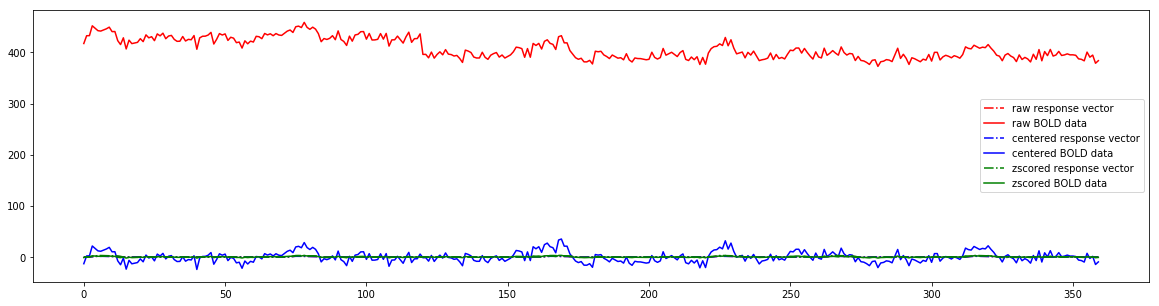

In [148]:
fig = plt.figure(figsize=(20, 5))
plt.plot(faces_response, 'r-.', label='raw response vector')
plt.plot(timeseries_total, 'r', label='raw BOLD data')
plt.plot(faces_response_centered, 'b-.', label='centered response vector')
plt.plot(timeseries_total_centered, 'b', label='centered BOLD data')
plt.plot(faces_response_zscored, 'g-.', label='zscored response vector')
plt.plot(timeseries_total_zscored, 'g', label='zscored BOLD data')
plt.legend()

That's not a very useful plot, all we see is that there is a large difference between the raw and zscored data. Since the large mean of the raw BOLD data is so large, let's only concentrate on centered and z-scored time series:

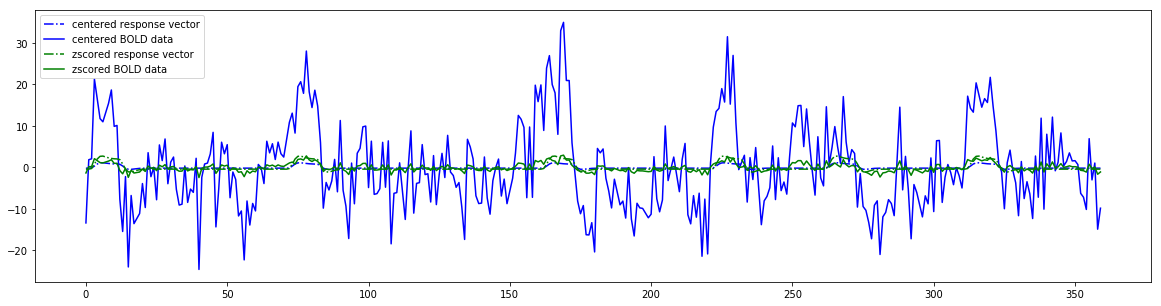

In [149]:
fig = plt.figure(figsize=(20, 5))
plt.plot(faces_response_centered, 'b-.', label='centered response vector')
plt.plot(timeseries_total_centered, 'b', label='centered BOLD data')
plt.plot(faces_response_zscored, 'g-.', label='zscored response vector')
plt.plot(timeseries_total_zscored, 'g', label='zscored BOLD data')
plt.legend()

The merely centered, but not z-scored plot of BOLD data is dominating. Let's make another plot where we focus on the z-scored data only:

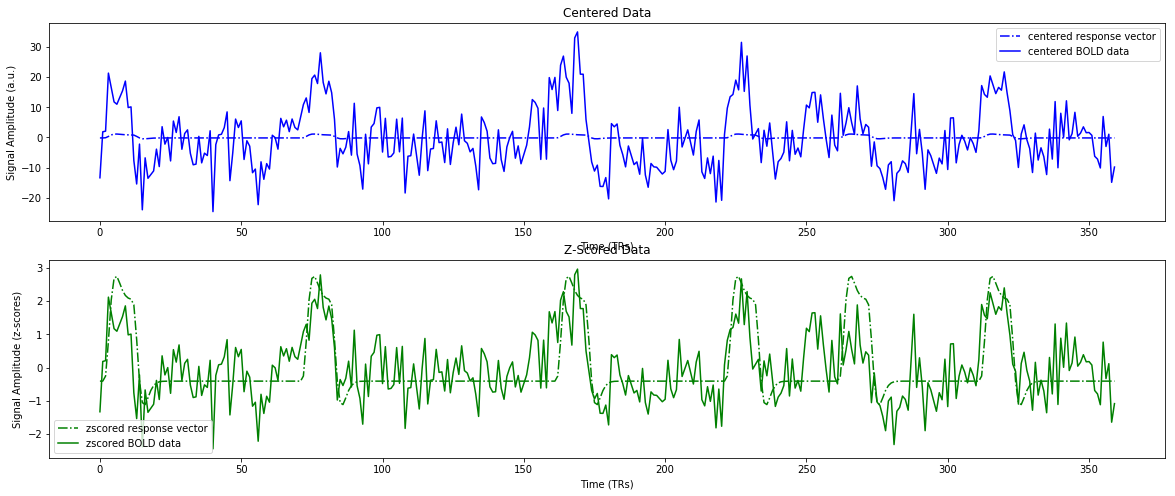

In [150]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(faces_response_centered, 'b-.', label='centered response vector')
plt.plot(timeseries_total_centered, 'b', label='centered BOLD data')
plt.legend()
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (a.u.)')
plt.title('Centered Data')
plt.subplot(2,1,2)
plt.plot(faces_response_zscored, 'g-.', label='zscored response vector')
plt.plot(timeseries_total_zscored, 'g', label='zscored BOLD data')
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (z-scores)')
plt.title('Z-Scored Data')
_ = plt.legend()

Interesting, the z-scored response vector seems to match the BOLD signal very well once we put them on the scame scale! When the response vector goes up, the BOLD signal vector goes up, and when the response vector is zero, the BOLD signal seems to fluctuate noisily around zero. Thus plotting two z-scored vectors together let's us see how the two change together, which is another way of thinking about what correlation is capturing!

### Breakout Session
Plot the z-scored `places` response vector and the z-scored places time series from above in the same way.

## Correlation 3: the Average Product of Z-Scored Data

We've used `np.corrcoef` several times to quantify the similarity between two vectors. What does this function do?

Let's take a look at how data 8 introduces correlation:

        Correlation is the average of the products of the two variables, when both variables are measured in standard units.

What does this mean? Two things:
1. We need to z-score both arrays we would like to correlate
2. We need to multiply corresponding values from the two arrays and average them

### Calculating Correlation with Line Plots
Let's try this with our face response and BOLD signal time series from above. We've already z-scored our response and BOLD signal data, but we'll introduce the calculations of correlation by doing them with algebra, and visualizing what that algebra does to the two vectors.

Let's start by plotting the raw response and BOLD data together in the same plot.  

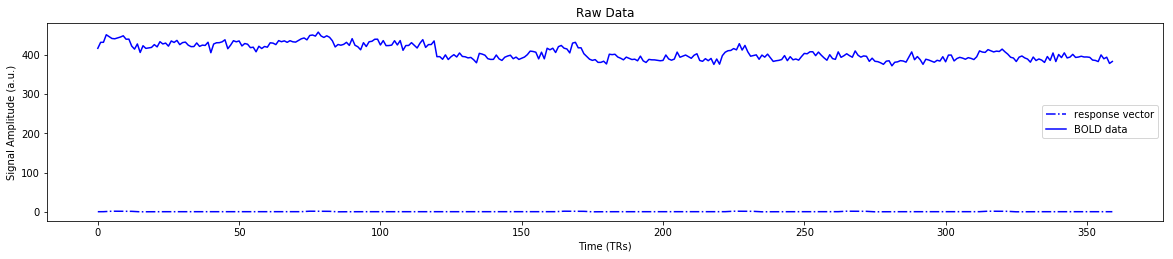

In [151]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(faces_response, 'b-.', label='response vector')
plt.plot(timeseries_total, 'b', label='BOLD data')
plt.legend()
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (a.u.)')
_ = plt.title('Raw Data')

Now let's re-plot both centered vectors. By removing the mean of each of the vectors we can focus on the way that both vectors move relative to their means, because both means are now `0`.

The algebra here is:

$$y_{centered} = y - y_{mean}$$
$$x_{centered} = x - x_{mean}$$

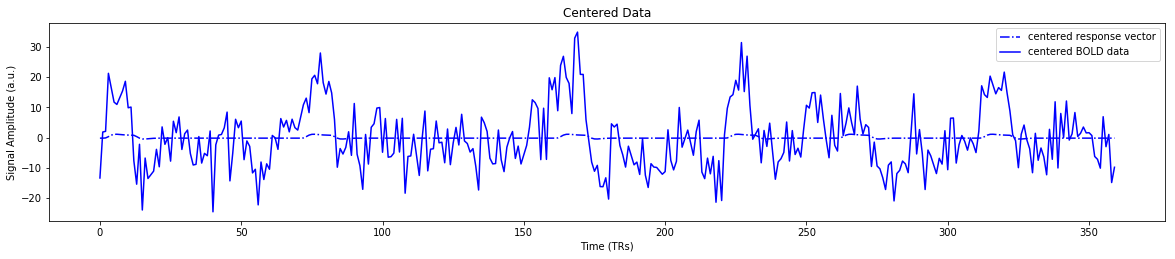

In [152]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(faces_response_centered, 'b-.', label='centered response vector')
plt.plot(timeseries_total_centered, 'b', label='centered BOLD data')
plt.legend()
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (a.u.)')
_ = plt.title('Centered Data')

Now let's re-plot both z-score vectors that have been scaled in addition to being centered. By scaling each of the vectors the amount of change relative to the center are in identical units for both vectors, so we can compare just the way they change on equal footing.

The algebra here is:

$$y_{zscore} = y_{centered} / y_{std}$$
$$x_{zscore} = x_{centered} / x_{std}$$

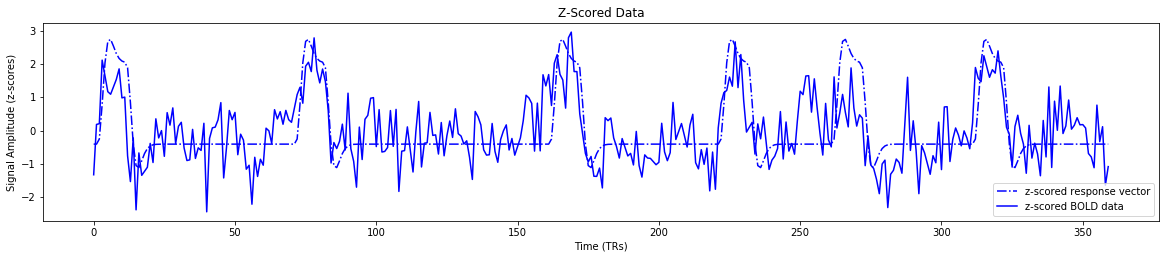

In [153]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(faces_response_zscored, 'b-.', label='z-scored response vector')
plt.plot(timeseries_total_zscored, 'b', label='z-scored BOLD data')
plt.legend()
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (z-scores)')
_ = plt.title('Z-Scored Data')

Now we'll take the product of the 2 z-scored vectors and plot that, along with the 2 z-scored vectors. If there is high correlation then this will make the large values larger because both of the vectors have large values. It will also make the smaller values smaller, because both vectors have smaller values. If there is low correlation, that means one vector goes up when the other doesn't, so the low value of the second vector will reduce the product of the two.

The algebra here is:

$$data_{product} = y_{centered} * x_{centered}$$

In [154]:
data_product = faces_response_zscored * timeseries_total_zscored

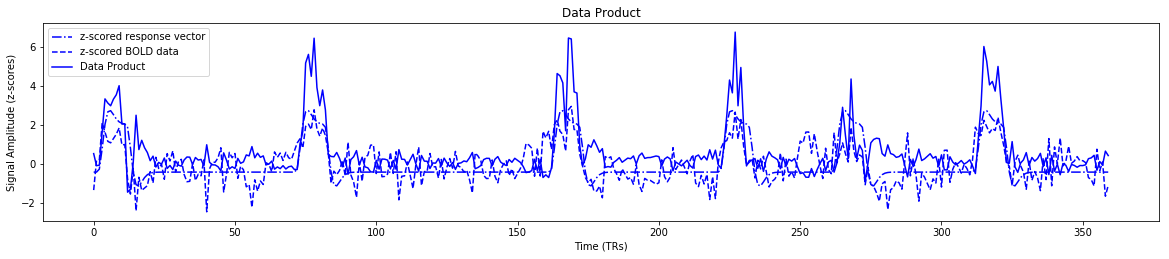

In [155]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(2,1,1)
plt.plot(faces_response_zscored, 'b-.', label='z-scored response vector')
plt.plot(timeseries_total_zscored, 'b--', label='z-scored BOLD data')
plt.plot(data_product, 'b', label='Data Product')
plt.legend()
plt.xlabel('Time (TRs)')
plt.ylabel('Signal Amplitude (z-scores)')
_ = plt.title('Data Product')

We see that the $data_{product}$ is very large where the data moves high together, and very low elsewhere. Now the final step is simply to take the average of $data_{product}$.

The algebra here is:

$$correlation = mean(data_{product})$$

In [156]:
correlation_stepwise = data_product.mean()
correlation_stepwise

0.61821396658409355

Now let's do what we just did in steps, all in one step.  We need to use the `timeseries_total_zscored` version of the time series data, since that was z-scored one run at a time, and `np.corrcoef` will zscore across the entire vector passed in.

In [ ]:
correlation_byhand = (scipy.stats.zscore(faces_response)* scipy.stats.zscore(timeseries_total_zscored)).mean()
correlation_byhand

And to confirm we did it right, let's compare that with the value from the `np.corrcoef` function.

In [ ]:
correlation_numpy = np.corrcoef(faces_response, timeseries_total_zscored)[0,1]
correlation_numpy

They're very close, so we've done it right!

## Summary of correlation
We just learned 3 ways to think about and visualize correlation:
* Correlation measures the extent to which two variables change together away from their respective means. 
* Correlation is the slope of a line that best reduces the squared error between data in a scatter plot.
* Correlation is the average product of the standardized scores of two variables.

Let's do an interactive plot to see all three of them together:

In [ ]:
# Constants to adjust how correlated and the size of the fake data
TARGET_CORRELATION = 0.6
FAKE_N = 30
MEAN_1 = 0
MEAN_2 = 10

# Create some fake correlated data
fake_data = np.random.multivariate_normal([MEAN_1,MEAN_2], [[1,TARGET_CORRELATION],[TARGET_CORRELATION,1]],FAKE_N)
fake_x = fake_data[:,0]
fake_y = fake_data[:,1]

In [ ]:
def plot_cor_time(n):

    # create a sequence for the length of the fake data
    t = range(n)
    
    # subset the fake data to the size specified by the slider
    cur_x = fake_x[:n]
    cur_y = fake_y[:n]

    # z-score (standardize) the fake data
    cur_x_z = scipy.stats.zscore(cur_x)
    cur_y_z = scipy.stats.zscore(cur_y)
    
    # take the mean of the fake data
    mean_fake_x = np.mean(cur_x)
    mean_fake_y = np.mean(cur_y)

    # calculate the correlation of the fake data
    fake_prods = (cur_x-mean_fake_x)*(cur_y-mean_fake_y)
    fake_mean_prods = np.mean(fake_prods)
    fake_prod_std = np.std(cur_x) * np.std(cur_y)
    fake_cor = fake_mean_prods / fake_prod_std

    # print out the values of the correlation
    print('Average of products: %.02f' % (fake_mean_prods))
    print('Product of std-dev: %.02f' % (fake_prod_std))
    print('Correlation: %.02f' % (fake_cor))

    # plot the line plots of the two variables
    plt.figure(figsize=(15,6))
    plt.subplot(3,1,1)
    plt.plot(t, cur_x, 'g', label='x')
    plt.plot(t, cur_x, 'go')
    plt.plot(t, cur_y, 'b', label='y')
    plt.plot(t, cur_y, 'bo')
    plt.plot(t, np.ones(n)*mean_fake_x, 'g--')
    plt.plot(t, np.ones(n)*mean_fake_y, 'b--')
    plt.legend()

    # plot the product of the difference between each data point and their respective means
    plt.subplot(3,1,2)
    plt.plot(t, np.ones(n)*fake_mean_prods, '--')
    plt.bar(t,fake_prods)

    # make a scatter plot of the standardized data, and draw the correlation line
    plt.subplot(3,4,9)
    plt.plot(cur_x_z, cur_y_z, 'o')
    fit = np.polyfit(cur_x_z, cur_y_z, deg=1)
    plt.plot(cur_x_z, fit[0] * cur_x_z + fit[1], color='red')

In [ ]:
interactive_plot = interactive(plot_cor_time, n=widgets.IntSlider(value=2, min=2, max=len(fake_x)))
output = interactive_plot.children[-1]
output.layout.height = '450px'
interactive_plot

### Breakout session

1. Change the TARGET_CORRELATION of the fake data to 2 or 3 numbers that are larger and smaller (but between -1 and 1, which is the range of correlation values). Try one very small correlation, one negative value near 1, and one positive value near 1. How do these changes affect the magnitude and direction of the bars in the above plot? And what does that mean for the correlation value?

2. Change the MEAN_2 of the fake data, making it equal to 5. Does this change the correlation? Why or why not?

## Correlation is a linear dependency

Earlier in the lecture we were using correlation coefficient to assess how much two sets of numbers relate to each other. There are some assumptions behind this, which we will take a look at here.

The general intuition, when we say **"these quantities are correlated"**, it means: There is some form of **dependency** between the two quantities. Meaning: knowledge of the one quantity might gain us more knowledge about the other quantity. This is a **loose definition**, but there exist mathematical ideas to quantify this.

### When we say *correlation*, we usually refer to *linear correlation* 
Or to frame it as a question: **How much does the point cloud resemble a line?**

We saw above that when 2 vectors are linearly related, without noise, they formed a perfect line, meaning a perfect positive correlation of 1. Let's see that again.

In [ ]:
x = np.random.randn(100)
y = 2 * x + 4
plt.scatter(x, y)
_ = plt.axis([-3, 3, -11, 11])

In [ ]:
np.corrcoef(x, y)

### Non-Linear Correlation

There can be many different **non-linear** ways that two vectors can relate to each other, or be dependent on each other. One simple way is when one vector is the square of the other, resulting in a parabola when plotted on a scatter plot. Let's create a `height_squared` vector that shows just that. 

In [ ]:
x = np.linspace(-1., 1., 51)
y = x ** 2
plt.plot(x, y, 'o')

We see that these two vectors create a parabola when plotted on a scatter plot! While there is definitely a relationship between the two, correlation cannot detect that relationship because it only looks for linear relationships. Let's look at what the correlation between these vectors is.

In [ ]:
np.corrcoef(x, y)

Almost close to zero! Let's plot the correlation line along with the data

In [ ]:
x_z = (x - x.mean()) / x.std()
y_z = (y - y.mean()) / y.std()
plt.plot(x_z, y_z, 'x')
c = np.mean(x_z * y_z)
plt.plot(x_z, c * y_z)

The correlation coefficient of this *perfect functional relation* is **zero**. Always keep this in mind when thinking about and evaluation correlation scores.

## Creating Correlation Flatmaps

In this section we will correlate all the voxels of a scan with the response vectors for the experiment. We will compute all of them together using array operations, and eventually even compute all of them together for stimulus types. Then we will display the results on flat maps.

### Preparing the data

Above we already loaded the BOLD data into the names `data1, data2, data3`. Let's check their shapes:

In [ ]:
data1.shape, data2.shape, data3.shape

Let's mask them to obtain the cortical voxels.

In [ ]:
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

In [ ]:
data1_masked = data1[:, mask]
data2_masked = data2[:, mask]
data3_masked = data3[:, mask]

Now let's perform z-scoring for the first array for all the voxels separately:

First, we compute the mean of each voxel time series:

In [ ]:
data1_masked.shape

In [ ]:
data1_mean = data1_masked.mean(axis=0)

In [ ]:
data1_mean.shape

We see that taking the mean along axis 0 gives us a mean value for each voxel.

We can also take the standard deviation along this axis:

In [ ]:
data1_stdev = data1_masked.std(axis=0)
data1_stdev.shape

Now we can do the z-scoring by subtracting the mean and dividing by the standard deviation for each column of the masked data array:

In [ ]:
data1_zscored = (data1_masked - data1_mean) / data1_stdev

## Breakout session
1. Do z-scoring for the other two arrays
2. Use `np.concatenate` or `np.vstack` to stack all three matrices vertically into an array named `data_zscored`.

### Computing correlation of one response vector to all the voxels

In order to compute the correlation of a response vector to all the voxels, we will first spell out the multiplication of that one response vector to all voxels.

In [ ]:
faces_response_times_voxels = faces_response_zscored * data_zscored

Huh, that didn't work!

To make this work, we need to turn `faces_response_zscored` into a column vector of shape `(360, 1)`.

In [ ]:
faces_response_zscored_column = faces_response_zscored.reshape(360, 1)

In [ ]:
faces_response_times_voxels = faces_response_zscored_column * data_zscored

That worked. Now we can take the mean along the time axis to compute the correlations with each voxel.

In [ ]:
corr_faces_data = faces_response_times_voxels.mean(axis=0)

In [ ]:
corr_faces_data.max(), corr_faces_data.min()

In [ ]:
vol_faces = cortex.Volume(corr_faces_data, 's01', 'catloc')
cortex.quickflat.make_figure(vol_faces)

We find that the `faces_response_zscored` correlates most strongly with voxels that we have already identified as belonging to areas processing faces!

### Breakout session
1. Compute the same correlation for `places` 